# Test Recurrent Policy with Extreme Parameter Variation 

In [1]:
import numpy as np
import os,sys



sys.path.append('../../../../RL_lib/Agents')
sys.path.append('../../../../RL_lib/Policies/PPO')
sys.path.append('../../../../RL_lib/Policies/Common')
sys.path.append('../../../../RL_lib/Utils')
sys.path.append('../../../Env')
sys.path.append('../../../Imaging')

%load_ext autoreload
%load_ext autoreload
%autoreload 2
%matplotlib nbagg
import os
print(os.getcwd())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/Users/briangaudet/Study/Subjects/MachineLearning/Projects/RL4GNC/Asteroid_CPO_seeker/Experiments/Extended/Test_HF


In [2]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:1000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

# Optimize Policy

Quaternion_attitude
Euler321 Attitude
C_cb: 
[[ 1.0000000e+00  0.0000000e+00 -0.0000000e+00]
 [ 0.0000000e+00 -1.0000000e+00  1.2246468e-16]
 [ 0.0000000e+00 -1.2246468e-16 -1.0000000e+00]]
[ 0.0000000e+00 -1.2246468e-16 -1.0000000e+00]
using max  pooling
V4: Output State type:  <function Sensor.optflow_state_range_dp1 at 0x1548de510>
<bound method Sensor.track_func1 of <sensor.Sensor object at 0x145871b38>>
<bound method Sensor.track_func1 of <sensor.Sensor object at 0x145871b38>>
6dof dynamics model 
thruster model: 
Inertia Tensor:  [[333.33333333   0.           0.        ]
 [  0.         333.33333333   0.        ]
 [  0.           0.         333.33333333]]
Lander Model: 
Reward_terminal equator
queue fixed
Flat Constraint
Attitude Constraint
Rotational Velocity Constraint
Position Hysterises Constraint


<IPython.core.display.Javascript object>


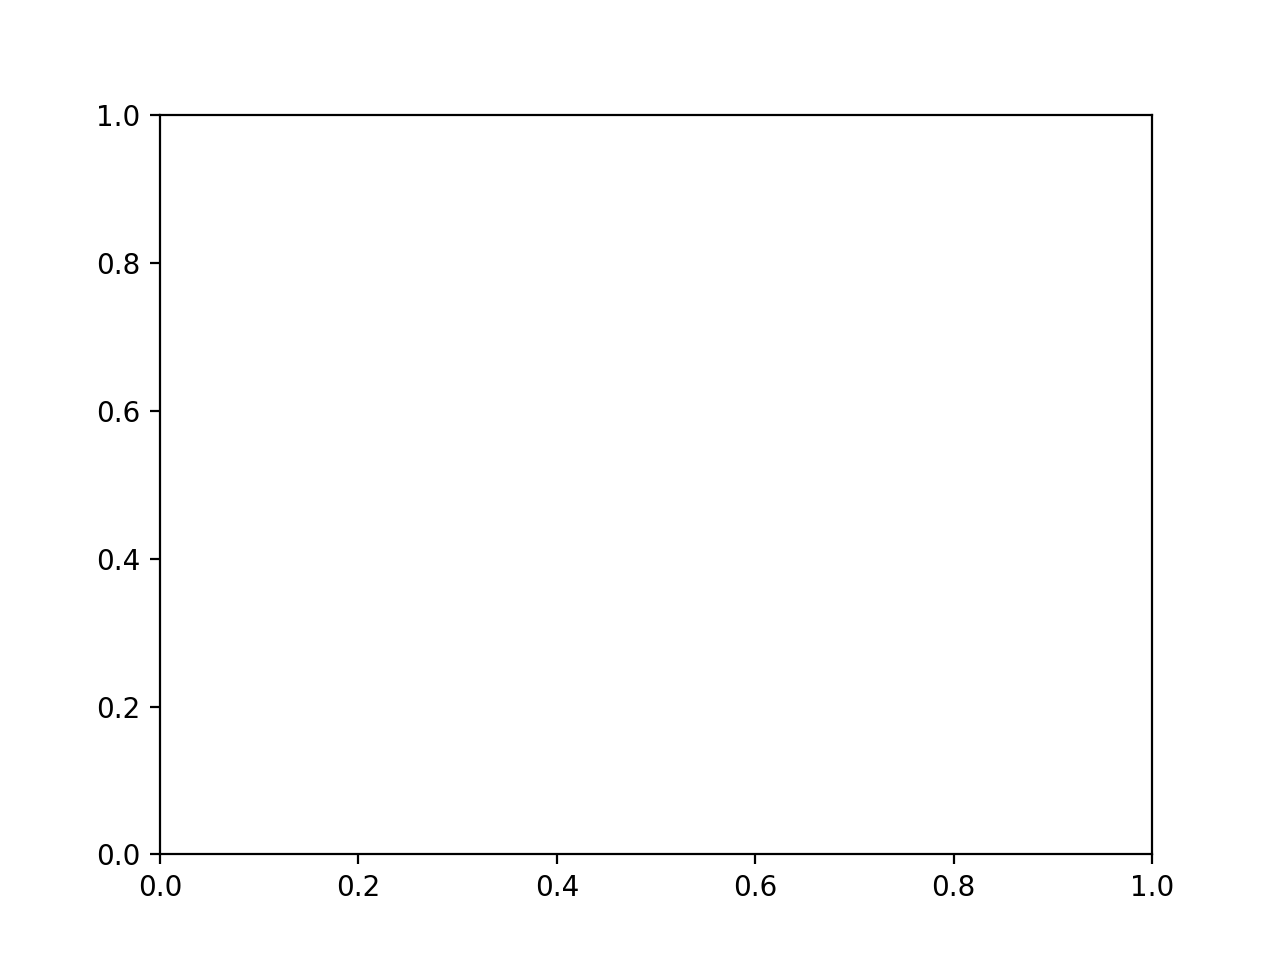

<IPython.core.display.Javascript object>


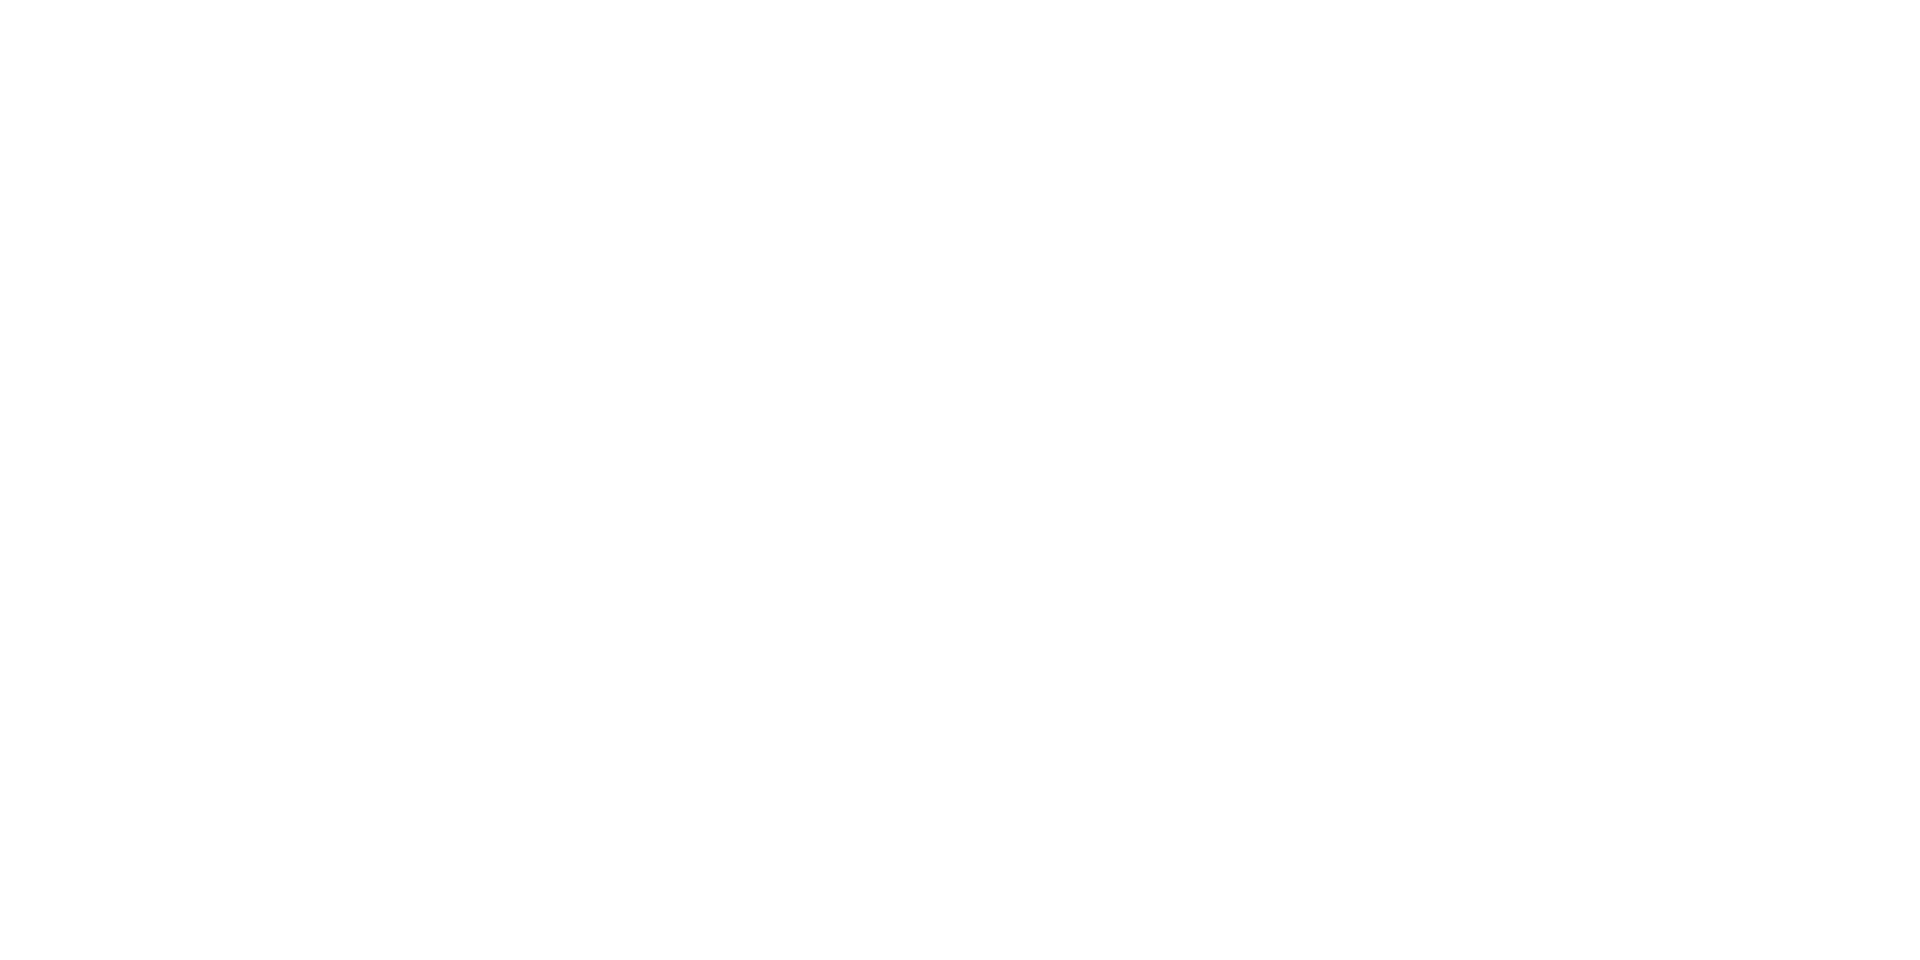

<IPython.core.display.Javascript object>


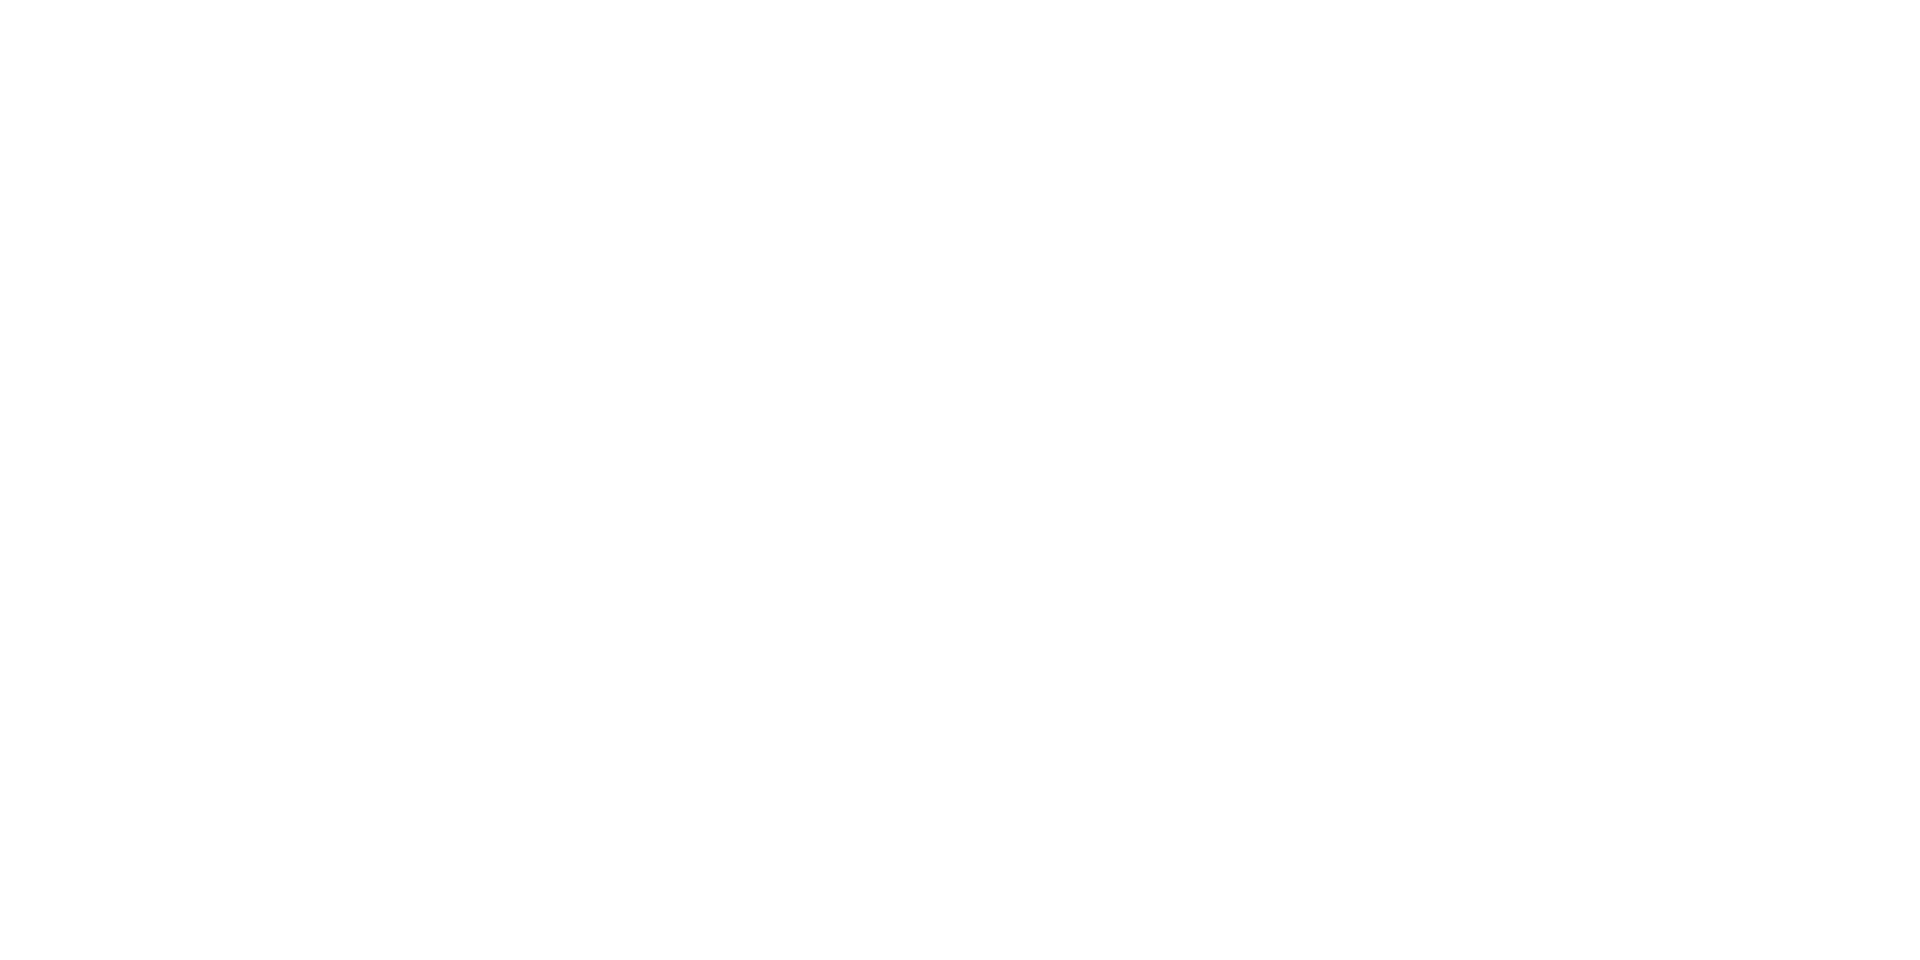

<IPython.core.display.Javascript object>


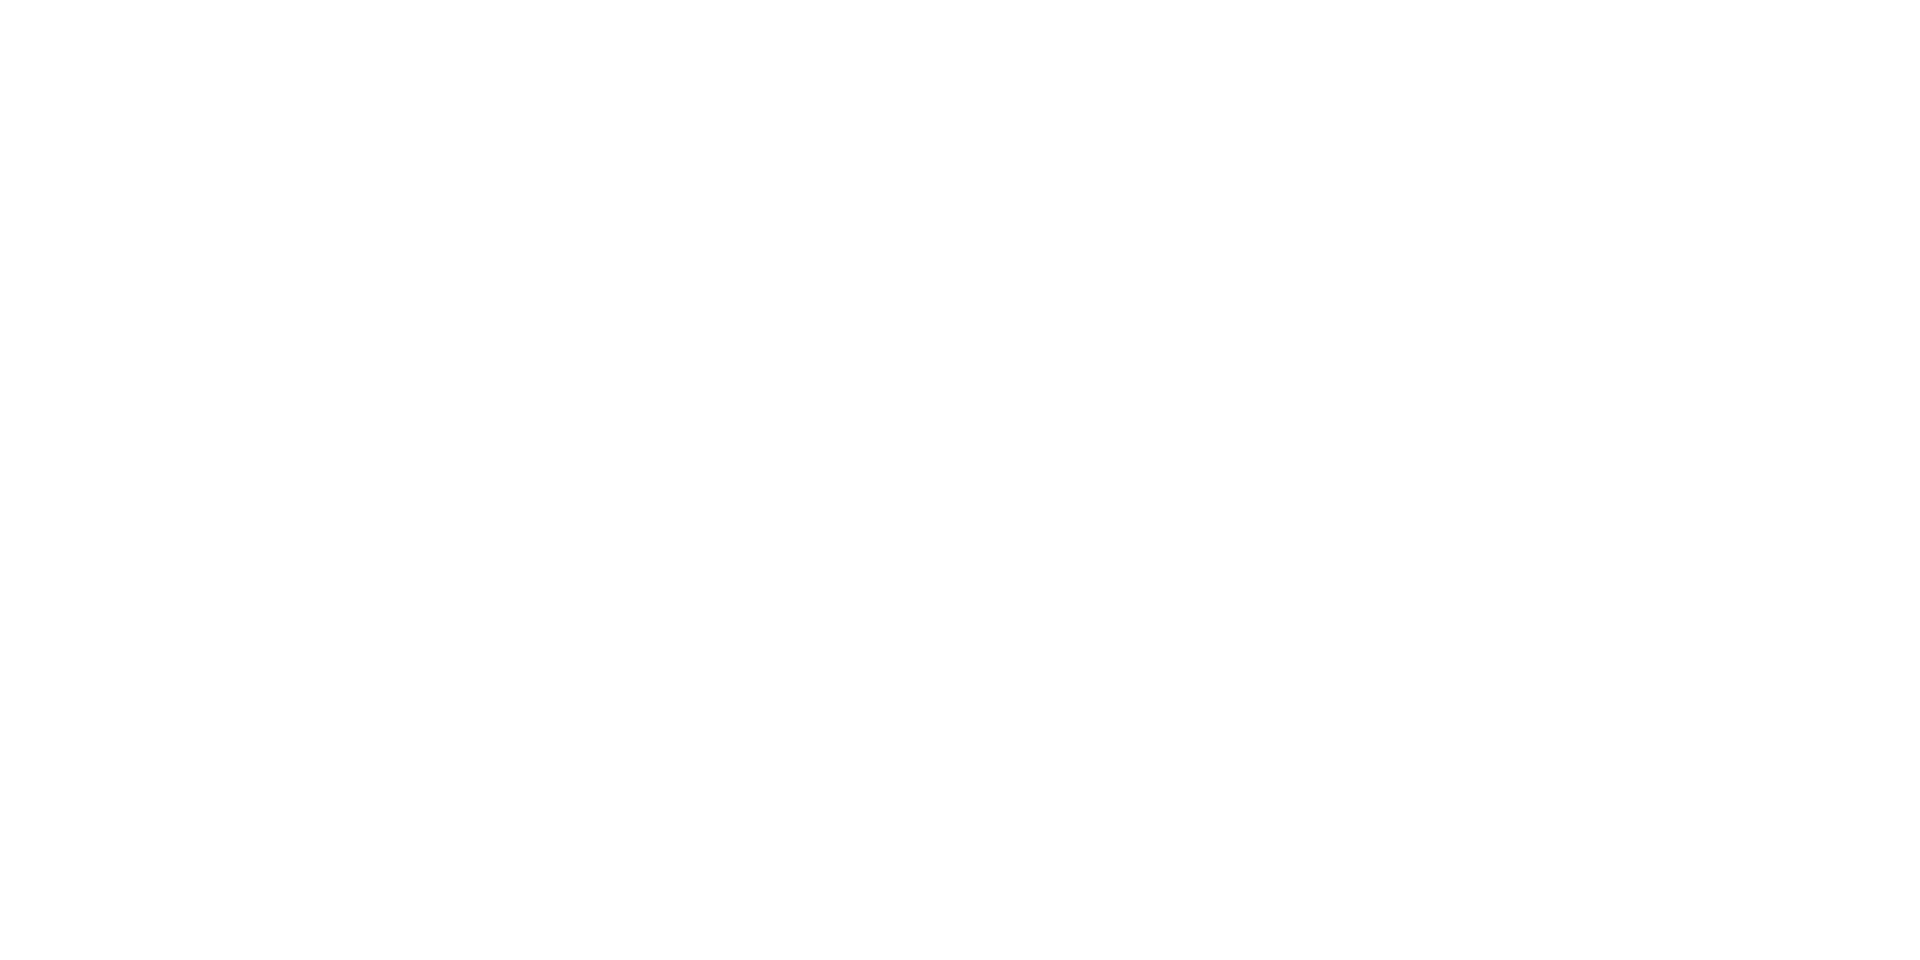

<IPython.core.display.Javascript object>


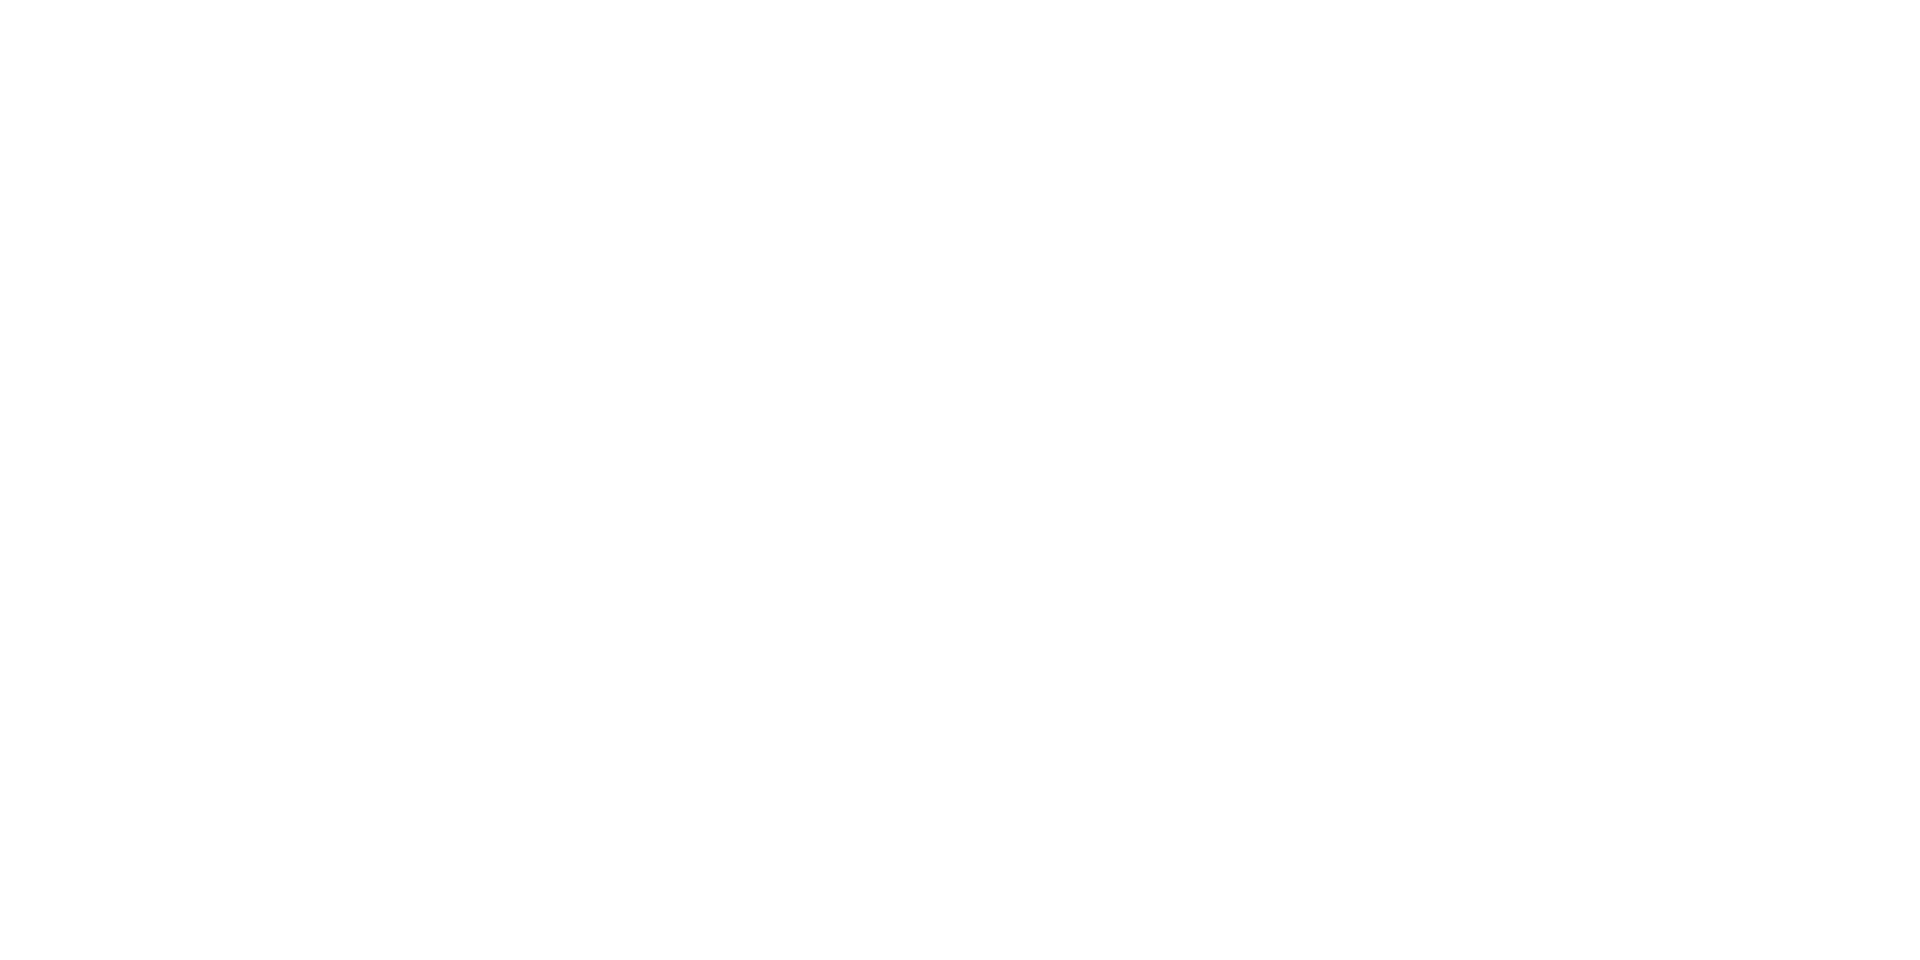

<IPython.core.display.Javascript object>


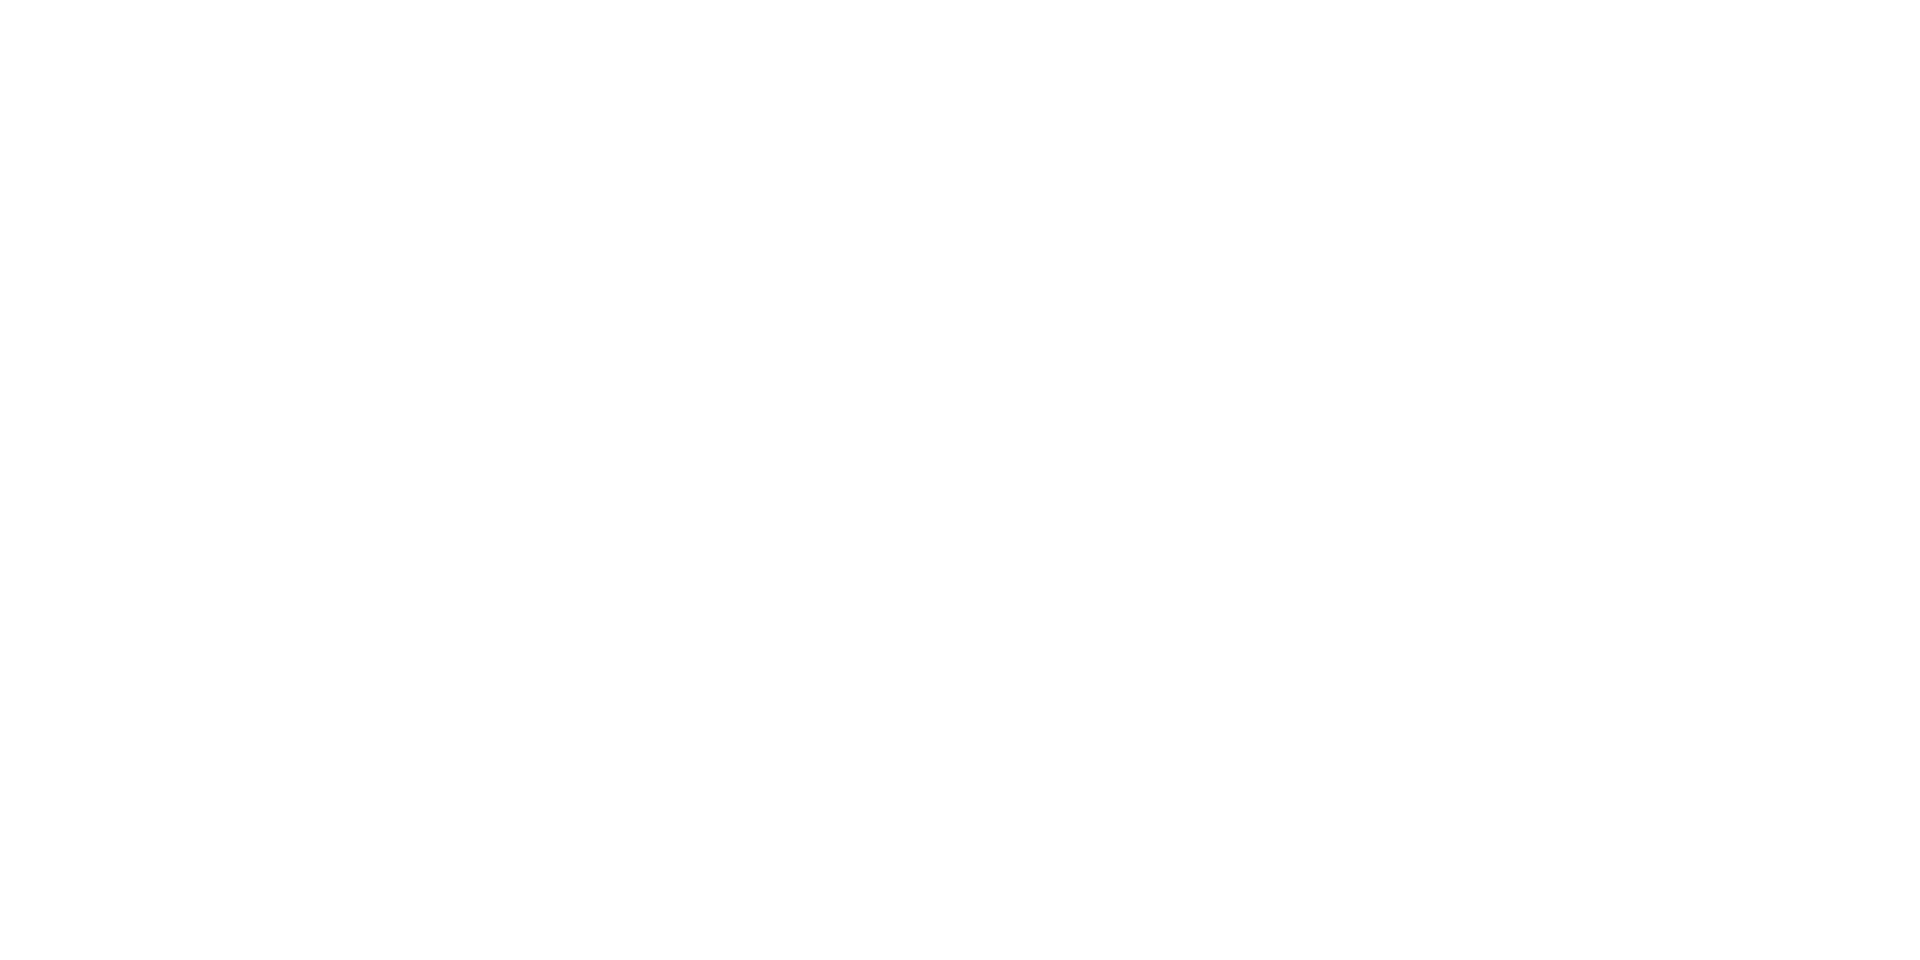

<IPython.core.display.Javascript object>


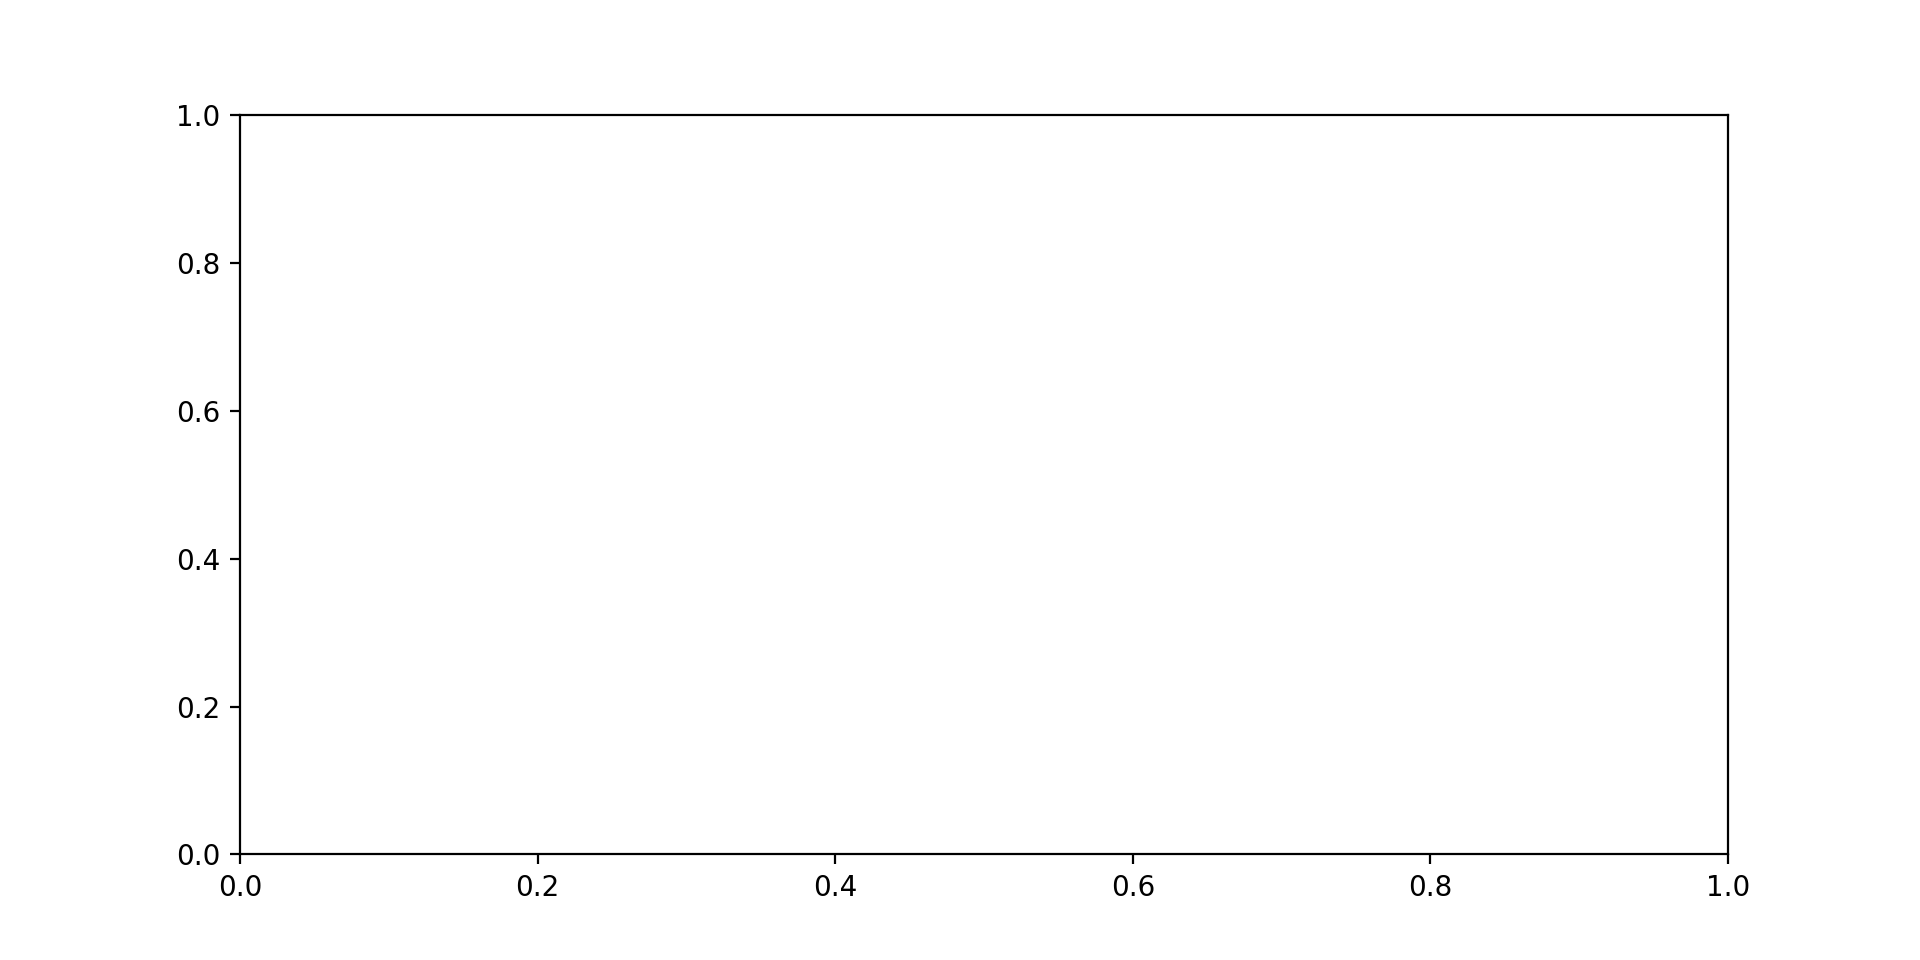

lander env RHL
Landing_icgen:
[[-1.]
 [ 1.]]
Policy with vectorized sample
	xn_init: layer  Linear(in_features=13, out_features=130, bias=True)
	xn_init: layer  GRUCell(130, 176)
	xn_init: layer  Linear(in_features=176, out_features=240, bias=True)
	xn_init: layer  Linear(in_features=240, out_features=24, bias=True)
Policy: recurrent steps > 1, disabling shuffle
	Test Mode:          False
	Clip Param:         0.1
	Shuffle :           False
	Shuffle by Chunks:  False
	Max Grad Norm:      30
	Recurrent Steps:    60
	Rollout Limit:      1
	Advantage Func:     <advantage_utils.Adv_default object at 0x156978978>
	Advantage Norm:     <function Adv_normalizer.apply at 0x153b43510>
	PD:                 <softmax_pd.Softmax_pd object at 0x156962f28>
	Loss Function:      <bound method Policy.calc_loss1 of <policy_ppo.Policy object at 0x1548f1390>>
Value Funtion
	xn_init: layer  Linear(in_features=13, out_features=130, bias=True)
	xn_init: layer  GRUCell(130, 25)
	xn_init: layer  Linear(in_feature

In [3]:
from env import Env
import env_utils as envu
from dynamics_model import Dynamics_model
from lander_model import Lander_model
from ic_gen import Landing_icgen
import rl_utils
import attitude_utils as attu
import optics_utils as optu
from arch_policy_vf import Arch

from policy_ppo import Policy
from softmax_pd import Softmax_pd as PD
from value_function import Value_function

import policy_nets as policy_nets
import valfunc_nets as valfunc_nets


from agent import Agent


import torch.nn as nn

from flat_constraint import Flat_constraint
from glideslope_constraint import Glideslope_constraint
from rh_constraint import RH_constraint
from no_attitude_constraint import Attitude_constraint
from w_constraint import W_constraint
from reward_attitude import Reward
from hf_asteroid import Asteroid

from thruster_model_cubesat import Thruster_model

from sensor import Sensor
from seeker import Seeker

landing_site_range = 10.0
landing_site = None #np.asarray([-250.,0.,0.])

asteroid_model = Asteroid(landing_site_override=landing_site, omega_range=(1e-5,5e-4))

ap = attu.Quaternion_attitude()

C_cb = optu.rotate_optical_axis(0.0, 0.0, np.pi)
r_cb = np.asarray([0,0,0])
fov=envu.deg2rad(90)
seeker = Seeker(attitude_parameterization=ap, C_cb=C_cb, r_cb=r_cb,
                radome_slope_bounds=(-0.05,0.05), range_bias=(-0.05,0.05),
                   fov=fov, debug=False)
sensor = Sensor(seeker, attitude_parameterization=ap,  use_range=True, apf_tau1=300, use_dp=False,
                      landing_site_range=landing_site_range,
                      pool_type='max', state_type=Sensor.optflow_state_range_dp1)
print(sensor.track_func)
sensor.track_func = sensor.track_func1
print(sensor.track_func)
logger = rl_utils.Logger()
dynamics_model = Dynamics_model(h=2)
thruster_model = Thruster_model(pulsed=True, scale=1.0, offset=0.4)
lander_model = Lander_model(asteroid_model, thruster_model, attitude_parameterization=ap, sensor=sensor, 
                             landing_site_range=landing_site_range, com_range=(-0.10,0.10),
                              attitude_bias=0.05, omega_bias=0.05)

lander_model.get_state_agent = lander_model.get_state_agent_sensor_att_w2

obs_dim = 13
action_dim = 12
actions_per_dim = 2
logit_dim = action_dim * actions_per_dim
recurrent_steps = 60

reward_object = Reward(landing_rlimit=2, landing_vlimit=0.1, 
                       tracking_bias=0.01, fov_coeff=-50., 
                       att_coeff=-0.20,
                       tracking_coeff=-0.5, magv_coeff=-1.0,
                       fuel_coeff=-0.10,  landing_coeff=10.0)

glideslope_constraint = Glideslope_constraint(gs_limit=-1.0)
shape_constraint = Flat_constraint()
attitude_constraint = Attitude_constraint(ap)
w_constraint = W_constraint(w_limit=(0.1,0.1,0.1), w_margin=(0.05,0.05,0.05))
rh_constraint = RH_constraint(rh_limit=150)

wi=0.05
ic_gen = Landing_icgen((800,1000), 
                           p_engine_fail=0.5,
                           engine_fail_scale=(0.5,1.0),
                           lander_wll=(-wi,-wi,-wi),
                           lander_wul=(wi,wi,wi),
                           attitude_parameterization=ap,
                           position_error=(0,np.pi/4),
                           heading_error=(0,np.pi/8),
                           attitude_error=(0,np.pi/16),
                           min_mass=450, max_mass=500,
                           mag_v=(0.05,0.1),
                           debug=False,
                           inertia_uncertainty_diag=10.0,
                           inertia_uncertainty_offdiag=1.0)

env = Env(ic_gen, lander_model, dynamics_model, logger,
          landing_site_range=landing_site_range,
          debug_done=False,
          reward_object=reward_object,
          glideslope_constraint=glideslope_constraint,
          attitude_constraint=attitude_constraint,
          w_constraint=w_constraint,
          rh_constraint=rh_constraint,
          tf_limit=5000.0,print_every=10,nav_period=6)




env.ic_gen.show()

arch = Arch()

policy = Policy(policy_nets.GRU1(obs_dim, logit_dim, recurrent_steps=recurrent_steps), 
                PD(action_dim, actions_per_dim),
                shuffle=False,
                kl_targ=0.001,epochs=20, beta=0.1, servo_kl=True, max_grad_norm=30, scale_vector_obs=True,
                init_func=rl_utils.xn_init)
value_function = Value_function(valfunc_nets.GRU1(obs_dim, recurrent_steps=recurrent_steps), scale_obs=True,
                                shuffle=False, batch_size=9999999, max_grad_norm=30, 
                                verbose=False)

agent = Agent(arch, policy, value_function, None, env, logger,
              policy_episodes=30, policy_steps=3000, gamma1=0.95, gamma2=0.995, 
              recurrent_steps=recurrent_steps, monitor=env.rl_stats)
fname = "optimize_WATTVW_FOV-AR=5-RPT"
policy.load_params(fname)

# Test Policy 

In [150]:

from isosphere import Isosphere
iso = Isosphere(recursion_level=4)
iso.perturb_axes(p_scale=0.05,r_scale=(400,300,280))
traj = np.load('traj_5.npy').item()
pos = np.asarray(traj['position'])
print(pos[-1])

[174.43575859 125.92909853 262.3383854 ]


<IPython.core.display.Javascript object>


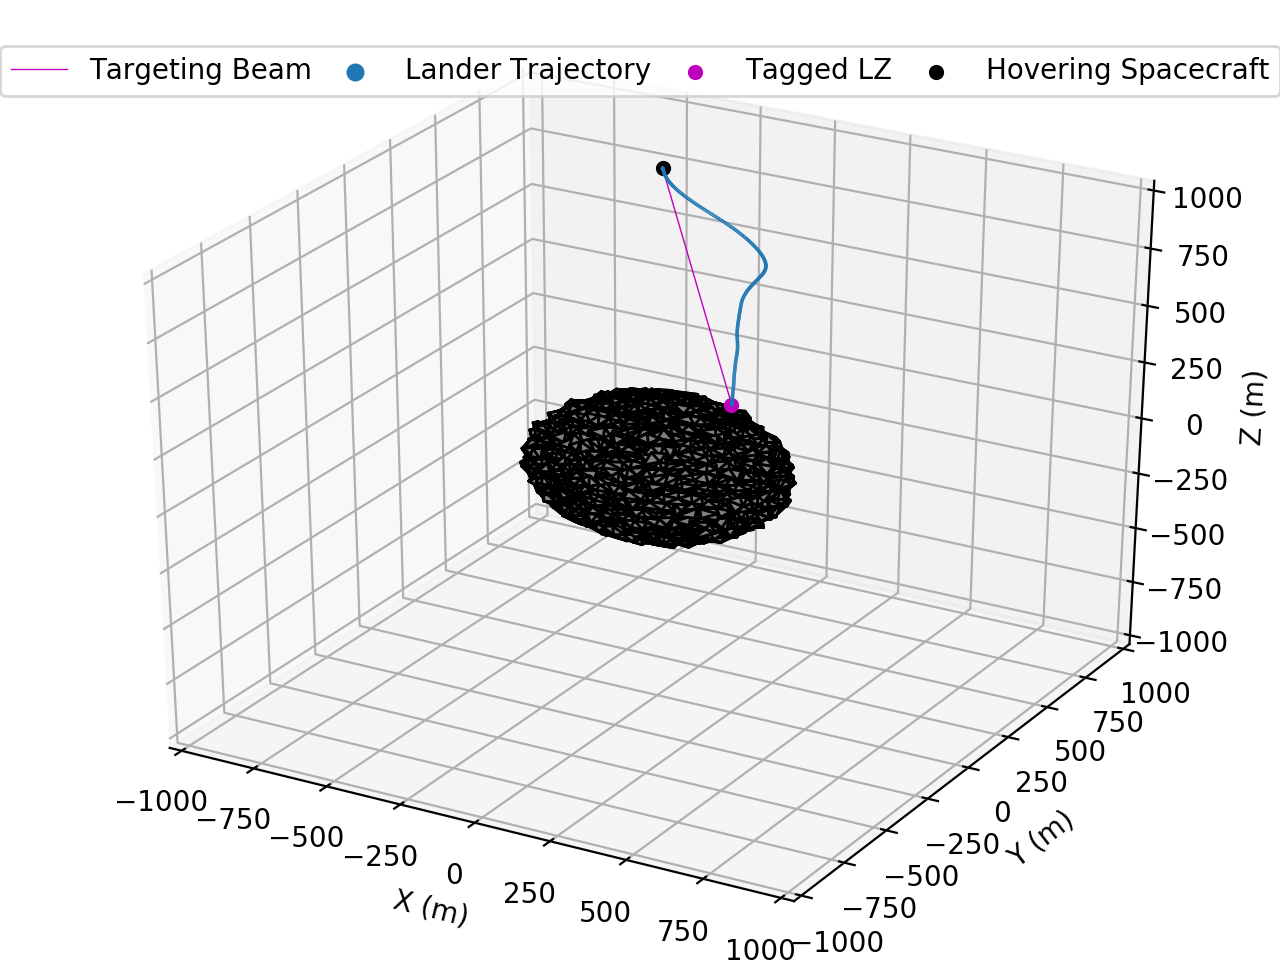

b


In [151]:
iso.show_bw(pos, axis_limit=1000, marker_loc=(174,125,262))

In [8]:
from isosphere import Isosphere
sm = np.load('rq36.npy')
print(sm.shape, np.min(sm,axis=0),np.max(sm,axis=0))
iso = Isosphere(recursion_level=2)


(1579014, 3) [-0.27307 -0.28166 -0.26785] [0.27653 0.28418 0.28718]


In [9]:
iso.pc2iso(sm)

<IPython.core.display.Javascript object>


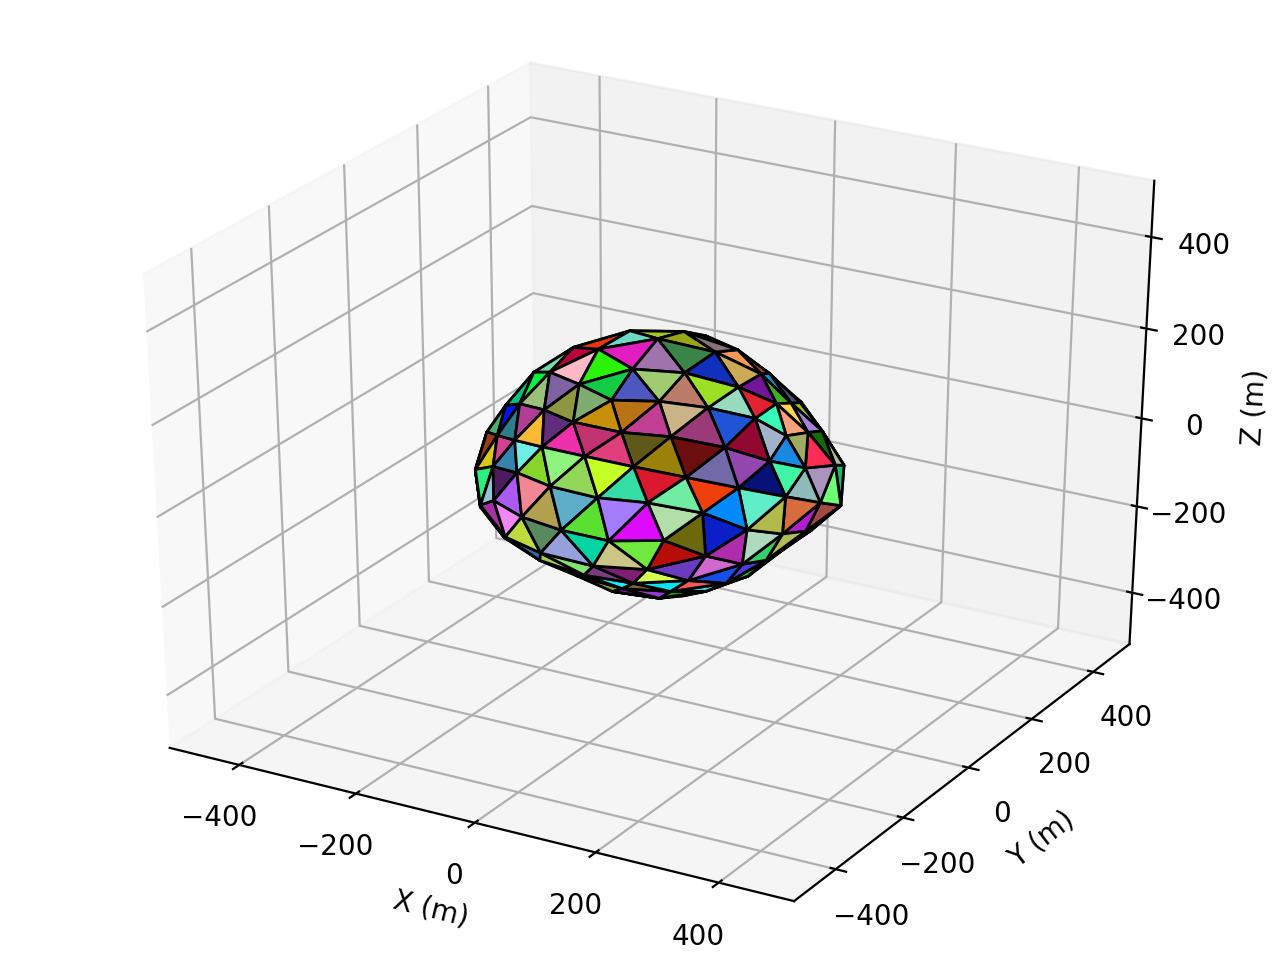

In [10]:
iso.show(axis_limit=500)

In [11]:
#iso.save('rq36_iso_r=2.npy')

In [122]:
print(len(iso.vertices))

642


Sphere has 1280 faces and 642 vertices
Min / Max Vertices:  [-271.35408392 -279.11033508 -264.77      ] [273.50369639 283.92       282.67      ]


<IPython.core.display.Javascript object>


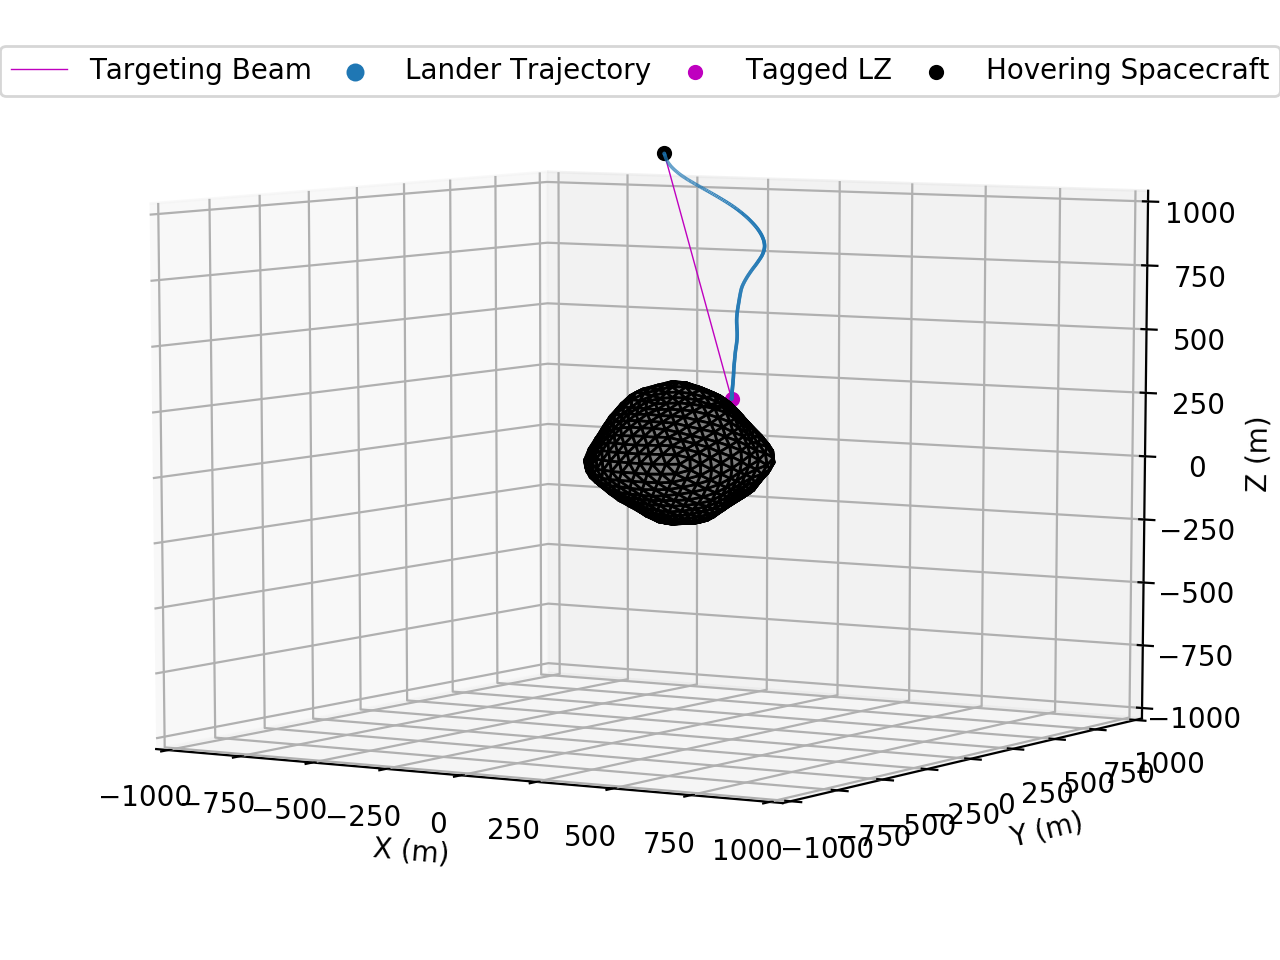

1 20
b


In [197]:
iso.load('rq36_iso.npy')
iso.adjust(1.0)
iso.show_bw(pos, axis_limit=1000, marker_loc=(174,125,262), offset=45.*np.ones(3))

In [183]:
#ito = np.loadtxt('itokawa.txt')

In [184]:
#np.save('itokawa.npy',ito)

(1579014, 3) [-0.25657 -0.15659 -0.11961] [0.30601 0.15024 0.12433]


<IPython.core.display.Javascript object>


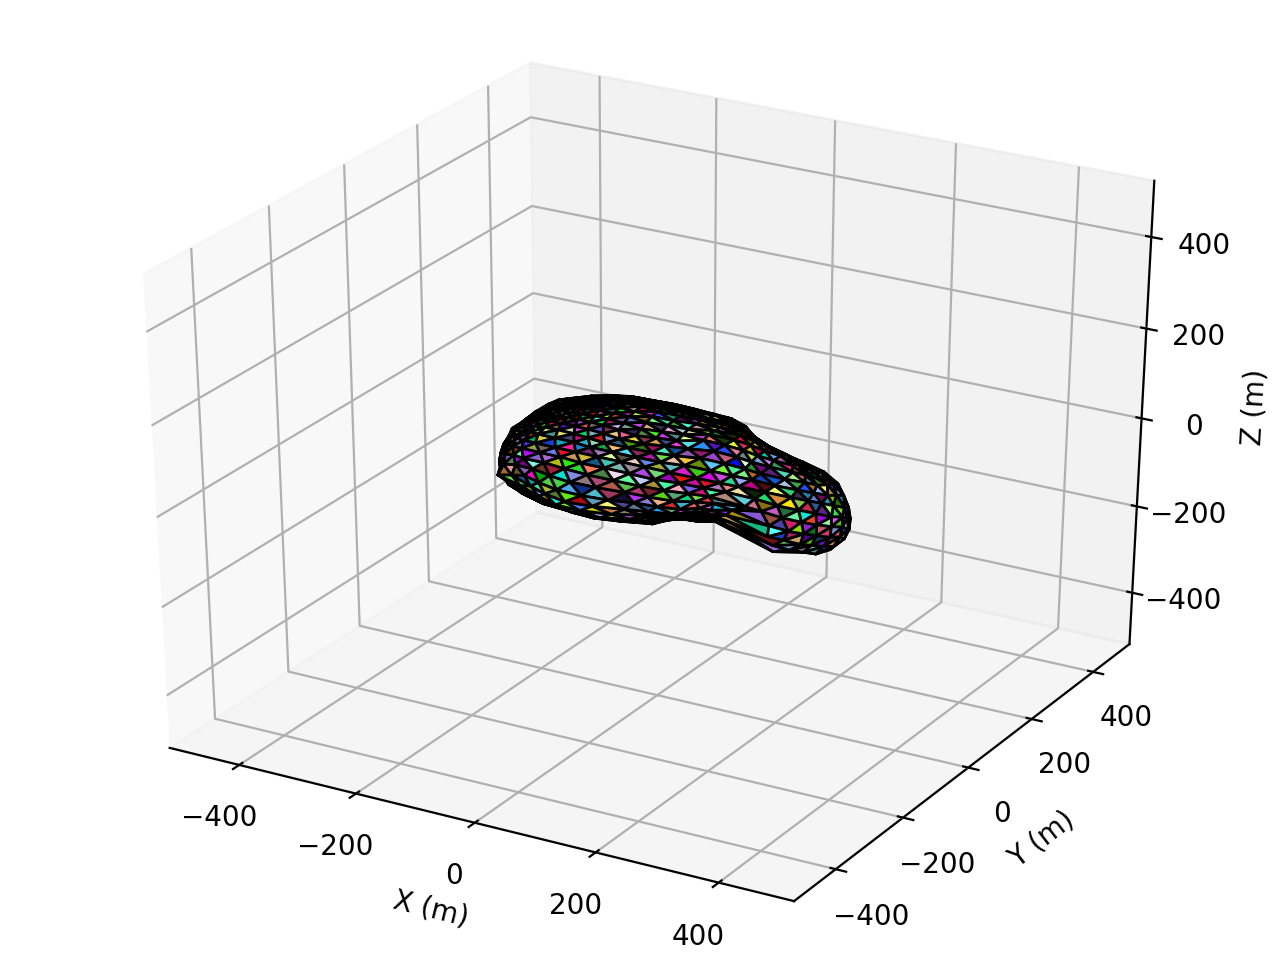

In [199]:
sm = np.load('itokawa.npy')

print(sm.shape, np.min(sm,axis=0),np.max(sm,axis=0))
iso = Isosphere(recursion_level=3)
iso.perturb_axes(p_scale=0.0,r_scale=(2.,1.,1.))
iso.pc2iso(sm)
iso.show(axis_limit=500)

In [188]:
#iso.save('itokawa_iso.npy')

<IPython.core.display.Javascript object>


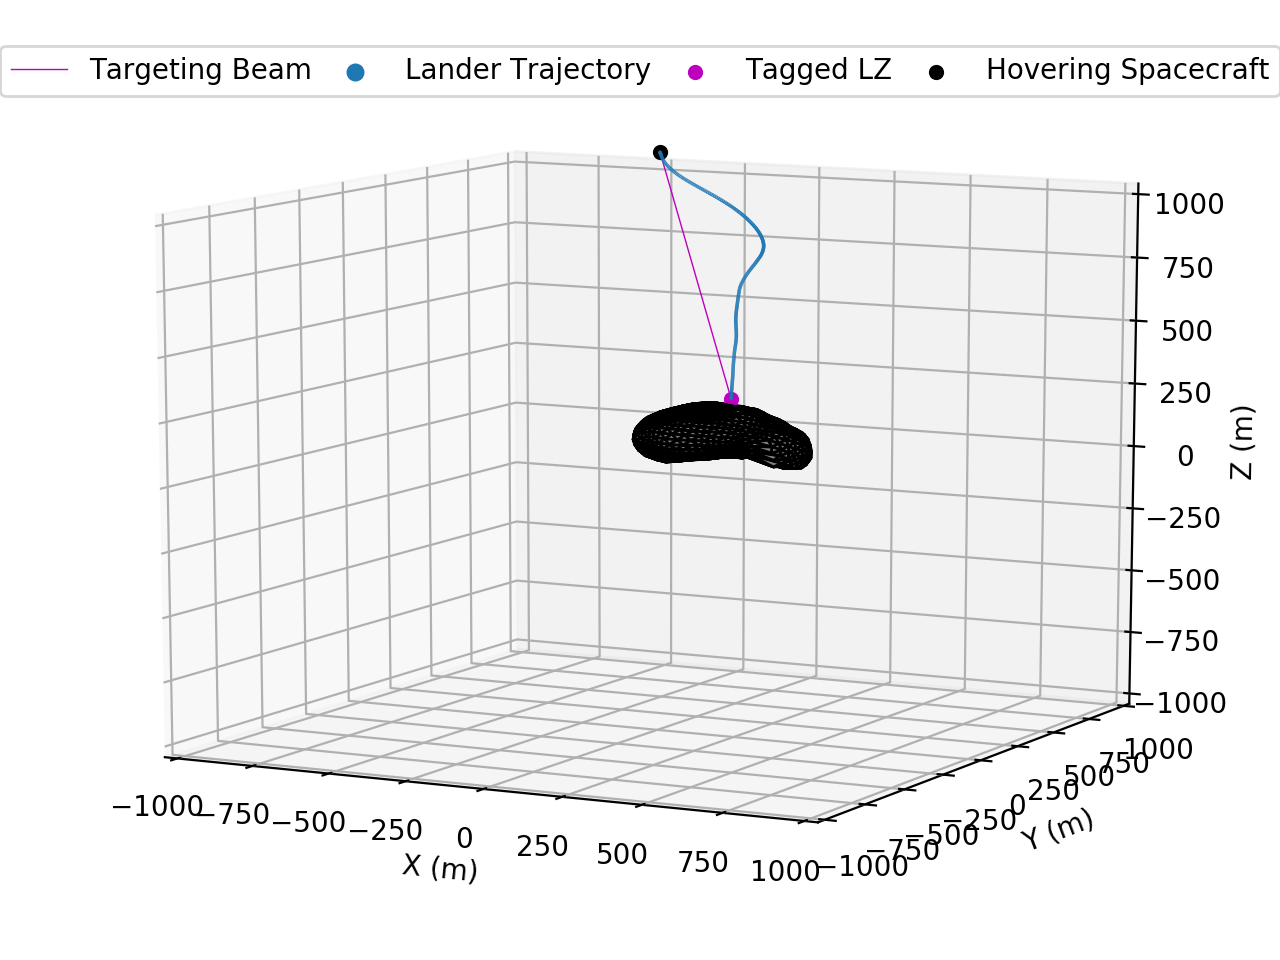

1 20
b


In [200]:
iso.show_bw(pos, axis_limit=1000, marker_loc=(174,125,262), offset=120.*np.ones(3))

Sphere has 1280 faces and 642 vertices
Min / Max Vertices:  [-271.35408392 -279.11033508 -264.77      ] [273.50369639 283.92       282.67      ]


<IPython.core.display.Javascript object>


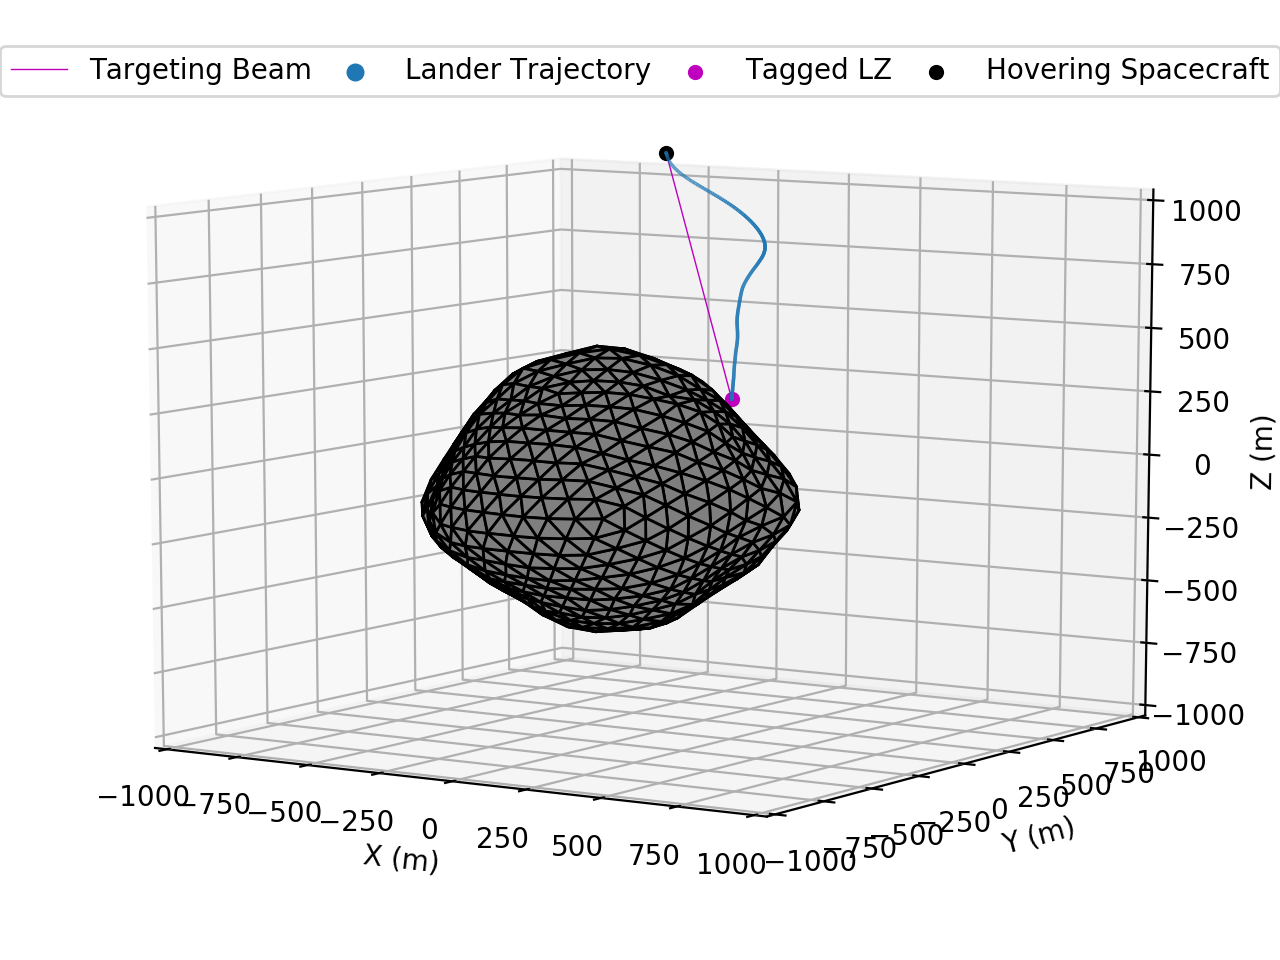

1 20
b


In [7]:
from isosphere import Isosphere
traj = np.load('traj_5.npy').item()
pos = np.asarray(traj['position'])
iso = Isosphere(recursion_level=3)
iso.load('rq36_iso.npy')
iso.adjust(2.0)
iso.show_bw(pos, axis_limit=1000, marker_loc=(174,125,262), offset=-100.*np.ones(3))